# Running and Postprocessing Heavy Models

The following assumes that a slow-running, CPU-intensive Model is being tested and only few models runs are allowed.

The model is transient and time series are to be compared.

In [1]:
import sys
import os
import platform

import pandas as pd
%matplotlib inline

# load IFM
ifmversion = '71'  # choose version here
arch = platform.architecture()[0][:2]
if 'FEFLOW' + ifmversion + '_ROOT' not in os.environ:
    raise EnvironmentError('FEFLOW' + ifmversion + '_ROOT Environment Variable not set!')
sys.path.insert(0, os.environ['FEFLOW' + ifmversion + '_ROOT'] + '\\bin' + arch)
import ifm
print("IFM API v."+str(ifm.getKernelVersion()))

IFM API v.7107


The first step is again to encapsulate the model in a Python function.

In [2]:
# define model function
def run_model(k = 1,    # [m/d]
              porosity = 0.05, # [-]
              comp = 0.0001 # [1/m]
              ):   
    
    doc = ifm.loadDocument("./example_data/Pit3_cal2.fem")

    # assign parameters and run model:
    for e in range(doc.getNumberOfElements()):
        doc.setMatConductivityValue2D(e, k)
        doc.setMatFlowStorativity(e, porosity)
        doc.setMatFlowCompressibility(e, comp)
    doc.startSimulator()
    
    # get results (fluxes and heads) and provide return as a dataframe
    times, values, itemnames = doc.getHistoryValues(ifm.Enum.HIST_HEAD, 0) 
    df_head = pd.DataFrame(values, columns=times, index=itemnames, )
    return df_head.T

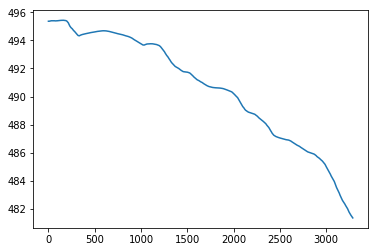

In [3]:
# do a test run with default parameters
# (runtime 30-60 seconds)
df_head = run_model()
df_head.MB11BSSM021.plot()

Load the prior information from a spreadsheet

In [4]:
import pandas as pd
df_ranges = pd.read_excel("./SENSAN.xlsx")
df_ranges.set_index("parameter", inplace=True)
df_ranges

,selection,-1,0,1
parameter,,,,
CONDX,Aquifer,0.100000,5.00000,20.0000
POR,Aquifer,0.010000,0.05000,0.1500
STOR,Aquifer,0.000001,0.00001,0.0005


Choose a test plan - here we simply copy paste from the previous lesson.

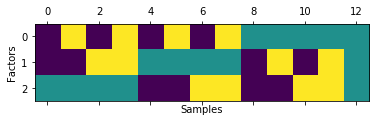

In [5]:
import pyDOE as pydoe
import matplotlib.pyplot as plt
%matplotlib inline

# 2-1 Fractional Factorial Design (for testing)
# design = pydoe.fracfact('a b ab')

# Box-Behnken Design with 3 factors
design = pydoe.bbdesign(3, center=1)
plt.matshow(design.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()

Convert the test plan to a dataframe

In [6]:
df_simulations = pd.DataFrame(design)
df_simulations.columns = df_ranges.index
df_simulations.index.name = "Scenario"
df_simulations

parameter,CONDX,POR,STOR
Scenario,,,
0,-1.0,-1.0,0.0
1,1.0,-1.0,0.0
2,-1.0,1.0,0.0
3,1.0,1.0,0.0
4,-1.0,0.0,-1.0
5,1.0,0.0,-1.0
6,-1.0,0.0,1.0
7,1.0,0.0,1.0
8,0.0,-1.0,-1.0


convert factor levels to real parameter values (keep a copy of the factor level)

In [7]:
# create copies of the columns ('_F' for factor level)
df_simulations["CONDX_F"] = df_simulations.CONDX
df_simulations["POR_F"] = df_simulations.POR
df_simulations["STOR_F"] = df_simulations.STOR

# change factor levels to parameter values
for i, row in df_simulations.iterrows():   
    row.CONDX = df_ranges.loc["CONDX", row.CONDX]
    row.POR = df_ranges.loc["POR", row.POR]
    row.STOR = df_ranges.loc["STOR", row.STOR]
df_simulations

parameter,CONDX,POR,STOR,CONDX_F,POR_F,STOR_F
Scenario,,,,,,
0,0.1,0.01,0.000010,-1.0,-1.0,0.0
1,20.0,0.01,0.000010,1.0,-1.0,0.0
2,0.1,0.15,0.000010,-1.0,1.0,0.0
3,20.0,0.15,0.000010,1.0,1.0,0.0
4,0.1,0.05,0.000001,-1.0,0.0,-1.0
5,20.0,0.05,0.000001,1.0,0.0,-1.0
6,0.1,0.05,0.000500,-1.0,0.0,1.0
7,20.0,0.05,0.000500,1.0,0.0,1.0
8,5.0,0.01,0.000001,0.0,-1.0,-1.0


Run the models. This time, we keep the results (head histories) in a dictionary.

In [8]:
results = {}
for i,row in df_simulations.iterrows():
    print("running scenario {} with".format(str(i)))
    print(row)
    results[i] = run_model(row.CONDX, row.POR, row.STOR)

running scenario 0 with
parameter
CONDX      0.10000
POR        0.01000
STOR       0.00001
CONDX_F   -1.00000
POR_F     -1.00000
STOR_F     0.00000
Name: 0, dtype: float64
running scenario 1 with
parameter
CONDX      20.00000
POR         0.01000
STOR        0.00001
CONDX_F     1.00000
POR_F      -1.00000
STOR_F      0.00000
Name: 1, dtype: float64
running scenario 2 with
parameter
CONDX      0.10000
POR        0.15000
STOR       0.00001
CONDX_F   -1.00000
POR_F      1.00000
STOR_F     0.00000
Name: 2, dtype: float64
running scenario 3 with
parameter
CONDX      20.00000
POR         0.15000
STOR        0.00001
CONDX_F     1.00000
POR_F       1.00000
STOR_F      0.00000
Name: 3, dtype: float64
running scenario 4 with
parameter
CONDX      0.100000
POR        0.050000
STOR       0.000001
CONDX_F   -1.000000
POR_F      0.000000
STOR_F    -1.000000
Name: 4, dtype: float64
running scenario 5 with
parameter
CONDX      20.000000
POR         0.050000
STOR        0.000001
CONDX_F     1.000000
POR_

Postprocessing

If the result is a time series, it is often helpfull to plot the ensemble of all time series. This immediately provides the spreading of the possible results (if the factor levels have been chosen appropriately).

The example below plots the ensemble of observation point "MB11BSSM021".

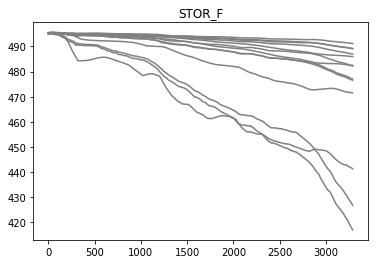

In [21]:
for k in results:
    results[k].PZ04BS4B030.plot(c="grey")
plt.title(par)
plt.show()

In [22]:
# plot all ensembles
#for obs in results[0].columns:
#    for k in results:
#        results[k][obs].plot()
#    plt.title(obs)
#    plt.show()

The sensitivity of different parameters can then be found by interpreting a color coded version of the same plot, where each color code represents a factor level (high, base, low): 

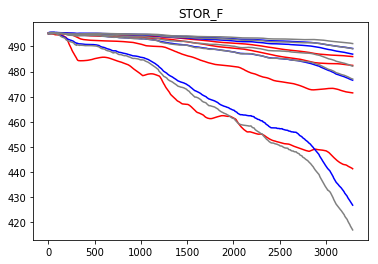

In [23]:
for k in results:
    results[k].PZ04BS4B030.plot(c=colors[df_simulations.loc[k, "CONDX_F"]])
plt.title(par)
plt.show()

We can then quickly iterate over the factors to get an overview of the sensitivity of the parameters.

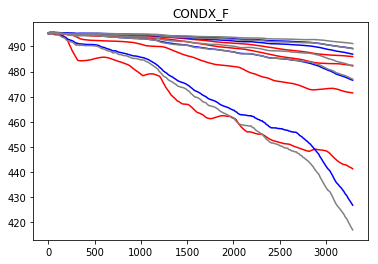

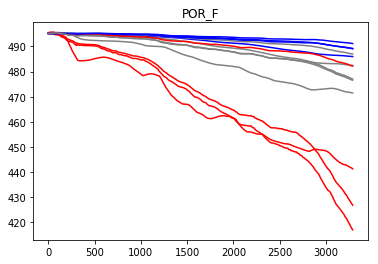

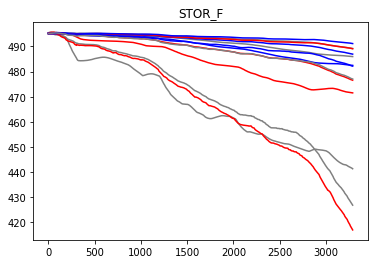

In [24]:
colors = {-1:'red', 0:'grey', 1:'blue'}

for par in ["CONDX_F", "POR_F", "STOR_F"]:
    for k in results:
        results[k].PZ04BS4B030.plot(c=colors[df_simulations.loc[k, par]])
    plt.title(par)
    plt.show()

The color code allows the interpretation of the sensitivity. Where all curves of the same color code (e.g. red - lower factor level) get separated from the the curves of the opposite color curve (e.g. blue - upper factor level), it sensitivity is clearly significant.

At the same time, the variation of the curves of the same color indicate the variance due to all other parameters, thus that the influence can be put into a relation.

Of the three parameters used here, the porosity shows signs of strong sensitivity.